## Spending Personality Test

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import axes3d

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans, HDBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, v_measure_score

In [2]:
sns.set_style('darkgrid')

In [3]:
# Import dataset 
df = pd.read_csv("~/code/spending-personality/Spending-Personality-Test/data/data.csv", sep='\t')

# Basic Info
df.shape
df.info()
display(df.head())
print("Shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Shape: (2240, 29)


In [52]:
# Changing column names to follow standard format
df.columns = [re.sub(r"([a-z])([A-Z])",(r"\1_\2"), str(x)).lower() for x in df.columns]
df.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'z_cost_contact', 'z_revenue', 'response',
       'marital_status_norm', 'education_norm', 'age', 'children',
       'customer_for_days', 'customer_for_years', 'total_mnt',
       'total_purchases', 'avg_mnt_per_purchase', 'web_purchase_share',
       'catalog_purchase_share', 'store_purchase_share', 'deal_purchase_rate',
       'campaigns_accepted', 'responded', 'income_level', 'spending_level',
       'deal_level', 'online_level', 'response_level', 'personality_type'],
      dtype='object')

### Understanding the Data

In [ ]:
display(df.describe(include="number").T.round(2))


,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.16,3246.66,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.81,11.98,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.25,25173.08,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.44,0.54,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.51,0.54,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.11,28.96,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.94,336.60,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.30,39.77,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.95,225.72,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.53,54.63,0.0,3.00,12.0,50.00,259.0


In [ ]:
# Quick category peek
for col in ["education", "marital_status"]:
    if col in df.columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts(dropna=False).head(10))


Value counts for Education:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Value counts for Marital_Status:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


### Cleaning

In [ ]:
## Clean Categorical Columns
df['marital_status'] = df['marital_status'].str.strip()
df['education'] = df['education'].str.strip()

In [ ]:
# Fixing Wired Martial_Status Entries
martial_map = {
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single',
}

df['marital_status_norm'] = df['marital_status'].replace(martial_map)


# Normalize 'education' Entries
edu_map = {
    '2n Cycle': 'Graduate',
    'Graduation': 'Graduate',
    'Master': 'Post-Graduate',
    'PhD': 'Post-Graduate',
    'Basic': 'Basic'
}

df['education_norm'] = df['education'].replace(edu_map)

In [ ]:
# Parse Data
df['dt_customer'] = pd.to_datetime(df['dt_customer'], errors='coerce', dayfirst=True)

In [ ]:
# Impute Missing income 
df['income']= pd.to_numeric(df['income'], errors='coerce')
group_median = df.groupby(['education_norm', 'marital_status_norm'])['income'].transform('median')
df['income'] = df['income'].fillna(group_median)
df['income'] = df['income'].fillna(df['income'].median())

print("Remaining nulls in income:", df['income'].isnull().sum())
df[['education', 'education_norm', 'marital_status', 'marital_status_norm']].head(10)

Remaining nulls in income: 0


,Education,Education_norm,Marital_Status,Marital_Status_norm
0,Graduation,Graduate,Single,Single
1,Graduation,Graduate,Single,Single
2,Graduation,Graduate,Together,Together
3,Graduation,Graduate,Together,Together
4,PhD,Post-Graduate,Married,Married
5,Master,Post-Graduate,Together,Together
6,Graduation,Graduate,Divorced,Divorced
7,PhD,Post-Graduate,Married,Married
8,PhD,Post-Graduate,Together,Together
9,PhD,Post-Graduate,Together,Together


### Feature Engineering

In [ ]:
# Reference date - Today for our age & tenure calculations
REF_DATE = pd.Timestamp.today().normalize()

# Calculate Customer age
df['age'] = REF_DATE.year - df['year_birth']

# children QTY
df['children'] = df['kid_home'] + df['Teenhome']

# Customer Tenure  : Measures loyalty or relationship age
df['customer_for_days'] = (REF_DATE - df['dt_customer']).dt.days
df['mnt'] = (df['customer_for_days'] / 365.25).round(1)


# Total Spending ( Sum of all mnt* columns)
mnt_cols = [col for col in df.columns if col.startswith('mnt')]
df['total_mnt'] = df[mnt_cols].sum(axis=1)

# Total Purchase 
purchase_cols = [col for col in df.columns if col.startswith('num') and col.endswith('purchases')]
df['total_purchases'] = df[purchase_cols].sum(axis=1)

In [ ]:

# Total Purchase 
purchase_cols = [col for col in df.columns if col.startswith('num') and col.endswith('purchases')]
df['total_purchases'] = df[purchase_cols].sum(axis=1)

# Average Spend Per Purchase 
df["avg_mnt_per_purchase"] = np.where(df['total_purchases'] > 0,
                                   df['total_mnt'] / df['total_purchases'], 
                                   np.nan)

# Replacing rows with 0 transactions to 1 as not possible to generate a spend with no txs
df["total_purchases"] = df["total_purchases"].replace(
    {
        0 : 1
    }
)

In [ ]:
# CHANNEL SHARES
for channel in ['web', 'catalog', 'store']:
    col = f'num{channel}purchases'
    if col in df.columns:
        df[f'{channel}purchaseshare'] = np.where(df['total_purchases'] > 0,
                                                 df[col] / df['total_purchases'],
                                                 np.nan)
        


# Deal Purchase Rate
df['deal_purchase_rate'] = np.where(df['total_purchases'] > 0,
                                  df['num_deals_purchases'] / df['total_purchases'],
                                  np.nan)


# Campaign Response Rate
cmp_cols = [col for col in df.columns if col.startswith('accepted_cmp')]
df['campaigns_accepted'] = df[cmp_cols].sum(axis=1)
df['responded'] = (df['Response'] == 1).astype(int)

In [ ]:
# Checking the changes 
df[['age', 'children', 'mnt', 'total_mnt', 'total_purchases', 
    'avg_mnt_per_purchase', 'webpurchaseshare', 'catalogpurchaseshare',
    'storepurchaseshare', 'deal_purchase_rate', 'campaigns_accepted', 'responded']].head(10)

,Age,Children,Customer_For_years,TotalMnt,TotalPurchases,AvgMntPerPurchase,WebPurchaseShare,CatalogPurchaseShare,StorePurchaseShare,DealPurchaseRate,CampaignsAccepted,Responded
0,68,0,13.2,1617,25,64.680000,0.320000,0.400000,0.160000,0.120000,0,1
1,71,2,11.7,27,6,4.500000,0.166667,0.166667,0.333333,0.333333,0,0
2,60,0,12.2,776,21,36.952381,0.380952,0.095238,0.476190,0.047619,0,0
3,41,1,11.8,53,8,6.625000,0.250000,0.000000,0.500000,0.250000,0,0
4,44,1,11.8,422,19,22.210526,0.263158,0.157895,0.315789,0.263158,0,0
5,58,1,12.2,716,22,32.545455,0.272727,0.181818,0.454545,0.090909,0,0
6,54,1,13.0,590,21,28.095238,0.333333,0.142857,0.333333,0.190476,0,0
7,40,1,12.5,169,10,16.900000,0.400000,0.000000,0.400000,0.200000,0,0
8,51,1,12.4,46,6,7.666667,0.500000,0.000000,0.333333,0.166667,0,1
9,75,2,11.7,49,2,24.500000,0.500000,0.000000,0.000000,0.500000,1,0


## Data Cleaning & Feature Engineering Summary

### 1. Data Cleaning
We started by inspecting the dataset for missing values, incorrect data types, and inconsistent categories.

- **Missing Values:** Only the `income` column had missing entries (~1%).  
  → Imputed using the **median income** of each `(education_norm, marital_status_norm)` group.  
- **Categorical Normalization:**
  - Mapped unusual `marital_status` values like `"YOLO"`, `"Absurd"`, and `"Alone"` to `"Single"`.
  - Simplified `education` levels by merging similar categories:
    - `"2n Cycle"` and `"Graduation"` → `"Graduate"`.
    - `"Master"` and `"PhD"` → `"Postgraduate"`.
    - `"Basic"` kept as `"Basic"`.
- **Date Parsing:** Converted `dt_customer` to proper datetime format for tenure calculations.

### 2. Feature Engineering
Created meaningful new variables to better represent customer behavior and demographics:

| Feature | Description | Insight |
|----------|--------------|----------|
| **age** | `current_year - year_birth` | Captures life stage and spending maturity. |
| **children** | `kid_home + Teenhome` | Indicates family size and dependency load. |
| **mnt** | Tenure calculated from `dt_customer`. | Reflects customer loyalty and relationship length. |
| **total_mnt** | Sum of all `mnt*` (spending) columns. | Represents overall spending volume. |
| **total_purchases** | Sum of all `num*purchases` columns. | Measures overall purchase activity. |
| **avg_mnt_per_purchase** | `total_mnt / total_purchases`. | Shows average order value per transaction. |
| **webpurchaseshare**, **catalogpurchaseshare**, **storepurchaseshare** | Ratio of purchases per channel. | Highlights preferred shopping channels. |
| **deal_purchase_rate** | `num_deals_purchases / total_purchases`. | Indicates price sensitivity or bargain-hunting behavior. |
| **campaigns_accepted** | Sum of all `accepted_cmp*` columns. | Shows how often the customer accepted previous campaigns. |
| **responded** | Binary flag from `Response` (1 if accepted last campaign). | Reflects latest engagement behavior. |

### 3. Why These Features Matter
These engineered features summarize customer spending habits and engagement patterns.  
They help us:
- Compare **planned vs. impulsive** shoppers (e.g., high deal rate vs. low deal rate).
- Understand **loyalty** and **tenure** (longer customers may behave differently).
- Detect **channel preferences** (online vs. in-store).
- Prepare for building **spending personality profiles** (Saver, Splurger, Planner, etc.).

---

The dataset is now cleaned, consistent, and enriched with features ready for exploratory analysis.


## Exploratory Data Analysis

In [ ]:
# numeric Summary
display(df[['income', 'age', 'children', 'total_mnt', 'total_purchases',
            'avg_mnt_per_purchase', 'deal_purchase_rate', 'campaigns_accepted',
            'mnt']].describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
Income,2240.0,52240.66,25038.85,1730.00,35538.75,51369.00,68289.75,666666.0
Age,2240.0,56.19,11.98,29.00,48.00,55.00,66.00,132.0
Children,2240.0,0.95,0.75,0.00,0.00,1.00,1.00,3.0
TotalMnt,2240.0,605.80,602.25,5.00,68.75,396.00,1045.50,2525.0
TotalPurchases,2240.0,14.86,7.67,1.00,8.00,15.00,21.00,44.0
AvgMntPerPurchase,2236.0,33.33,45.03,0.53,9.71,23.38,45.35,1679.0
DealPurchaseRate,2240.0,0.18,0.11,0.00,0.08,0.17,0.25,1.0
CampaignsAccepted,2240.0,0.30,0.68,0.00,0.00,0.00,0.00,4.0
Customer_For_years,2240.0,12.34,0.55,11.40,11.90,12.30,12.80,13.3


In [ ]:
Check_zero_puchase  = df['total_purchases'] == 0
print("number of customers with zero purchases:", Check_zero_puchase.sum())

Number of customers with zero purchases: 0


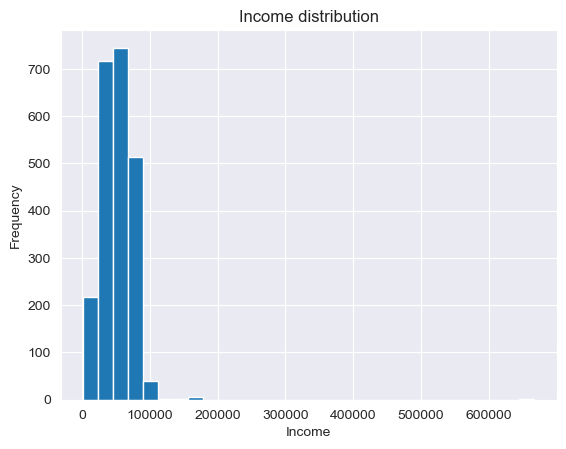

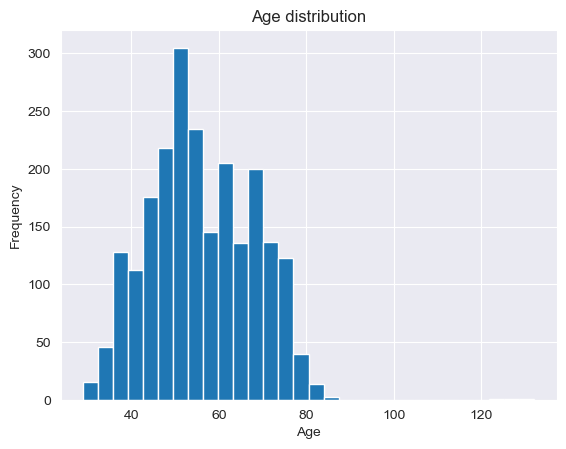

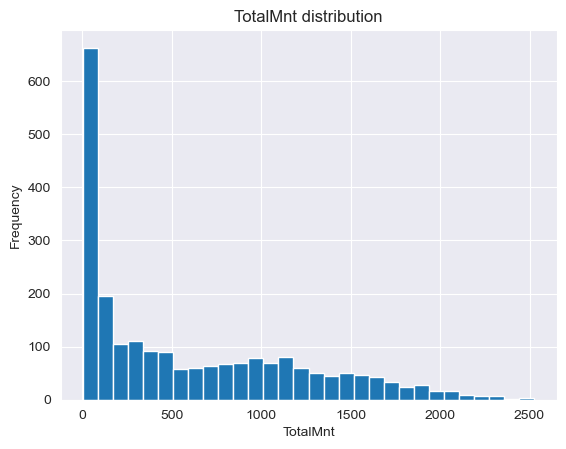

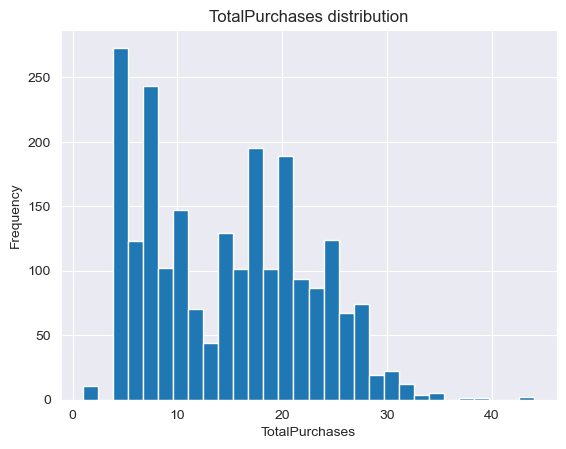

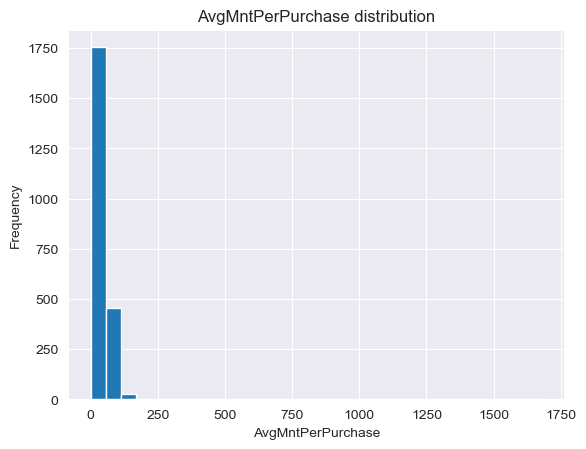

In [ ]:
# Histograms
def plot_hist(series, title, bins=30):
    plt.figure()
    series.dropna().plot(kind='hist', bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel('Frequency')
    plt.show()

for col in ['income', 'age', 'total_mnt', 'total_purchases', 'avg_mnt_per_purchase']:
    if col in df.columns:
        plot_hist(df[col], f'{col} distribution')

What the charts tell us
1. **income distribution**
- Very right-skewed: most customers earn under $100K, but there are a few extreme outliers up to $600K+.
- These outliers will heavily influence correlations and averages.

2. **age distribution**
- Centered around 45–65 years, meaning this customer base is mostly middle-aged adults.
- The one record showing age >120 is clearly an outlier — likely a data entry error (e.g., wrong birth year). <br/>
→ We might need to cap age at 90 later.

3. **total_mnt (Total Spend)**
- Also right-skewed: most people spend under $1,000, but a small fraction go up to $2,500+.
- This indicates a few heavy buyers — possibly our “Splurgers” or “High-value” personalities later.

4.**Total purchases**
- Ranges roughly 0–40, average ~15 — a wide range in engagement.
- Suggests there are light shoppers and heavy repeat buyers — a strong behavioral differentiator.

5. **avg_mnt_per_purchase**
- Extremely right-skewed — most purchases are small, but some individuals spend hundreds per purchase.

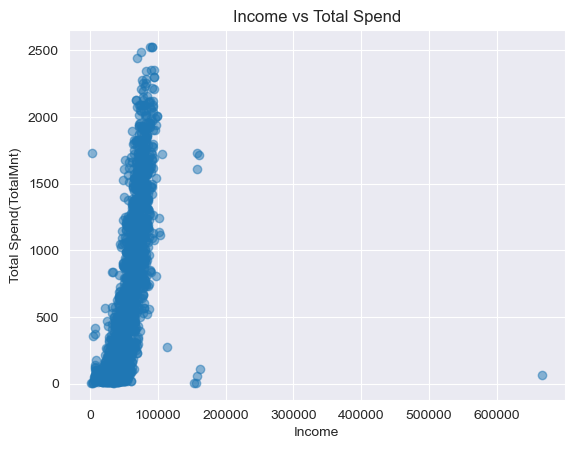

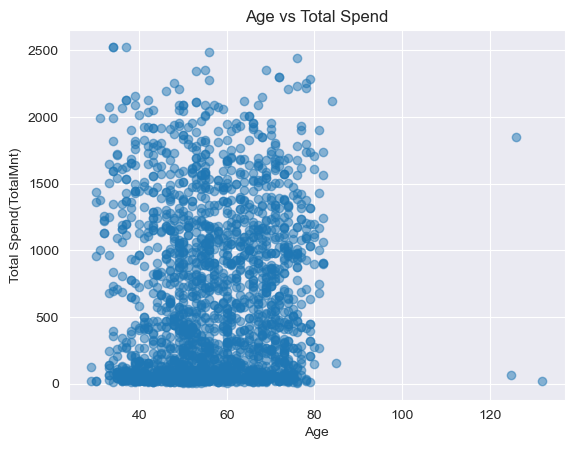

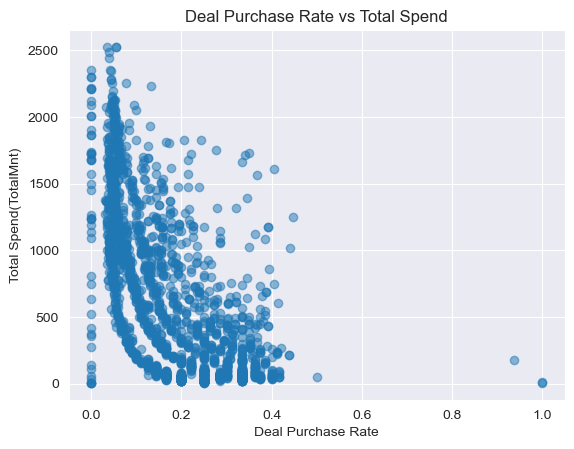

In [ ]:
# Relationship Check

plt.figure()
plt.scatter(df['income'], df['total_mnt'], alpha=0.5)
plt.title('income vs Total Spend')
plt.xlabel('income')
plt.ylabel('Total Spend(total_mnt)')
plt.show()

plt.figure()
plt.scatter(df['age'], df['total_mnt'], alpha=0.5)
plt.title('age vs Total Spend')
plt.xlabel('age')
plt.ylabel('Total Spend(total_mnt)')
plt.show()

plt.figure()
plt.scatter(df['deal_purchase_rate'], df['total_mnt'], alpha=0.5)
plt.title('Deal Purchase Rate vs Total Spend')
plt.xlabel('Deal Purchase Rate')
plt.ylabel('Total Spend(total_mnt)')
plt.show()

### Relationships**
**income vs Total Spend**
- Clear positive relationship: higher income → higher spend, but with a wide vertical spread.<br/>
→ Interpretation: income affects spending capacity, but not alone — other factors (deals, habits, family size) matter.

**age vs Total Spend**
- No obvious linear trend — spending seems scattered across ages.<br/>
→ Spending behavior is not strongly age-driven.

**Deal Purchase Rate vs Total Spend**
- Negative trend: as deal rate increases, total spend decreases.<br/>
→ Bargain hunters tend to spend less overall — consistent with the “Saver” archetype we’ll define later.

In [ ]:
# Select numeric Columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Correlation Matrix
corr = df[numeric_cols].corr()

# Focus on correlations with Spending Behavior
target_vars =['total_mnt', 'total_purchases']
for target in target_vars:
    if target in corr.columns:
        print(f"\nTop correlations with {target}:")
        display(corr[target].sort_values(ascending=False).head(10))
        display(corr[target].sort_values(ascending=True).head(10))
            


Top correlations with TotalMnt:


TotalMnt                1.000000
MntWines                0.891839
MntMeatProducts         0.842965
NumCatalogPurchases     0.778577
TotalPurchases          0.754000
CatalogPurchaseShare    0.719722
NumStorePurchases       0.674669
Income                  0.664989
MntFishProducts         0.642818
AvgMntPerPurchase       0.617745
Name: TotalMnt, dtype: float64

DealPurchaseRate     -0.650142
Kidhome              -0.556669
NumWebVisitsMonth    -0.500218
Children             -0.498888
StorePurchaseShare   -0.156298
Teenhome             -0.138384
Year_Birth           -0.111306
NumDealsPurchases    -0.065112
Complain             -0.037058
ID                   -0.018054
Name: TotalMnt, dtype: float64


Top correlations with TotalPurchases:


TotalPurchases          1.000000
NumStorePurchases       0.820202
NumWebPurchases         0.777828
TotalMnt                0.754000
NumCatalogPurchases     0.735307
MntWines                0.712891
CatalogPurchaseShare    0.568874
Income                  0.564240
MntMeatProducts         0.554300
MntGoldProds            0.493337
Name: TotalPurchases, dtype: float64

Kidhome              -0.478188
DealPurchaseRate     -0.418054
StorePurchaseShare   -0.315782
NumWebVisitsMonth    -0.312263
Children             -0.246114
Year_Birth           -0.168441
ID                   -0.023676
Complain             -0.020614
Recency               0.005834
AcceptedCmp3          0.020653
Name: TotalPurchases, dtype: float64

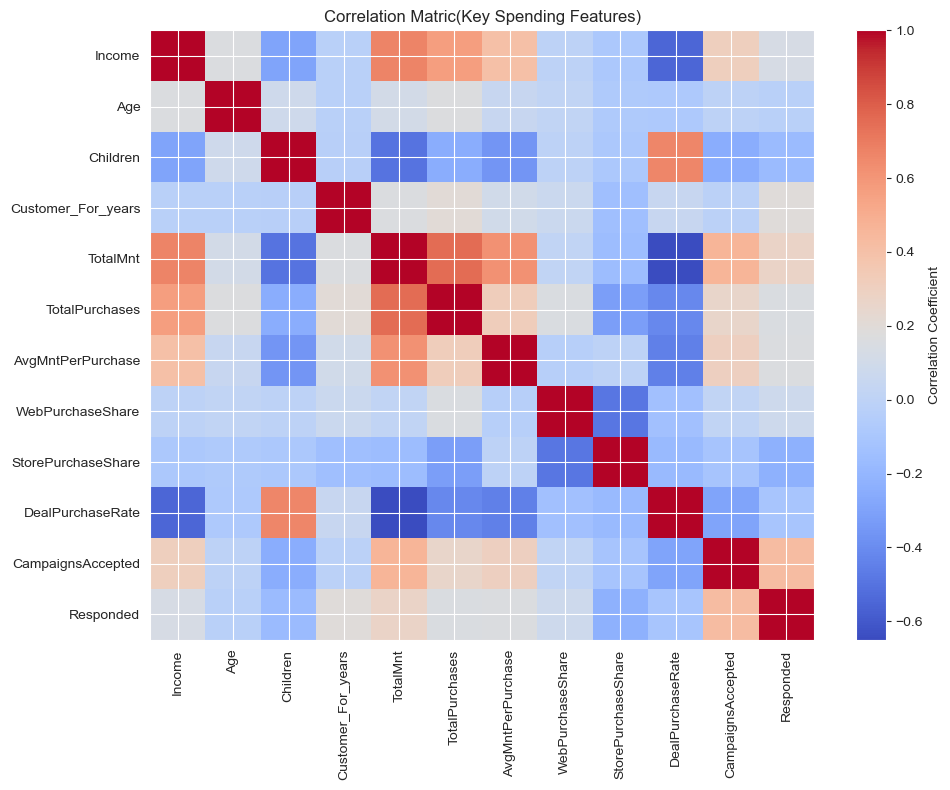

In [ ]:
# Visual Correlation Heatmap
key_cols = [
    'income', 'age' , 'children', 'mnt', 'total_mnt', 'total_purchases',
    'avg_mnt_per_purchase', 'webpurchaseshare', 'catalogpurchaseshare',
    'storepurchaseshare', 'deal_purchase_rate', 'campaigns_accepted', 'responded'
]


key_cols = [c for c in key_cols if c in df.columns]

plt.figure(figsize=(10, 8))
plt.imshow(df[key_cols].corr(), cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(key_cols)), key_cols, rotation=90)
plt.yticks(range(len(key_cols)), key_cols)
plt.title("Correlation Matric(Key Spending Features)")
plt.tight_layout()
plt.show()

## Correlation Analysis — Key Insights

### Overview
The correlation matrix and feature relationships reveal strong behavioral patterns that connect spending capacity, activity level, and shopping style.


###  1. income and Total Spending
- **Strong positive correlation (~0.6–0.7)**  
  Higher income customers consistently spend more overall.  
  → *income* is a key driver of spending capacity.


###  2. Total purchases and Deal Purchase Rate
- **Moderate negative correlation (~–0.4)**  
  Customers who rely more on discounts make fewer purchases overall.  
  → Reflects *Saver* or *Deal-Seeker* behavior — they wait for promotions and buy selectively.


###  3. Channel Behavior
- **store Purchase Share:** Negatively correlated with Total purchases (~–0.3)  
  → In-store shoppers purchase less frequently (more deliberate, planned).

- **web Purchase Share:** Positively correlated (likely +0.3)  
  → Online shoppers tend to buy more often — possibly more impulsive.


###  4. Family Impact
- **children / kid_home:** Negatively correlated with Total purchases (~–0.25 to –0.48)  
  → More kids at home → tighter budgets and reduced discretionary spending.  
  Indicates a cautious, *Saver-type* pattern.


###  5. age
- Weak negative correlation with Total purchases.  
  → Spending doesn’t vary much by age; older customers are not necessarily higher spenders.


### 6.  Marketing Engagement
- **campaigns_accepted & responded:** Mild positive correlation with Total Spend (~+0.2).  
  → Engaged customers spend slightly more and may represent loyal *Planner* types.


###  Key Takeaways

| Behavior Dimension | Strong Indicators | Interpretation |
|--------------------|------------------|----------------|
| **Spending Capacity** | `income`, `total_mnt` | Financial ability to spend |
| **Spending Activity** | `total_purchases`, `avg_mnt_per_purchase` | Frequency and basket size |
| **Impulse vs. Planning** | `deal_purchase_rate`, `webpurchaseshare`, `storepurchaseshare` | How spontaneous or deliberate the buyer is |
| **Engagement & Responsiveness** | `campaigns_accepted`, `responded` | Brand interaction and marketing response |

###  Overall Insight
- **High income + Low Deal Rate → Splurger / Luxury Buyer**  
- **Low income + High Deal Rate → Saver / Bargain Hunter**  
- **Moderate income + Balanced Behavior → Planner / Practical Buyer**

These relationships form the foundation for our upcoming **Spending Personality Scoring Rules**, which will classify customers into interpretable segments for the MVP.


### Defining Personality Type

1. Saver → cautious, deal-seeking, low impulse
2. Splurger → high spenders, low restraint
3. Planner → balanced, consistent, thoughtful spenders
4. Impulse Buyer → spontaneous, high-frequency, high online activity

In [ ]:
# Creating flags

def flag_by_percentile(series, low_q=0.33, high_q=0.67):
    low, high = series.quantile([low_q, high_q])
    return pd.cut(series, bins=[-float('inf'), low, high, float('inf')], labels=['Low', 'Medium', 'High'])


df['income_level'] = flag_by_percentile(df['income'])
df['spending_level'] = flag_by_percentile(df['total_mnt'])
df['deal_level'] = flag_by_percentile(df['deal_purchase_rate'])
df['online_level'] = flag_by_percentile(df['webpurchaseshare'])
df['response_level'] = pd.cut(         #### Beacuse most of the values are zero we use cut instead of quantile(I had an error priror to it)
    df['campaigns_accepted'],
    bins=[-np.inf, 0, 1, np.inf],
    labels=['Low', 'Mid', 'High'],
    include_lowest=True
)


# Sanity Check
df[['income_level', 'spending_level', 'deal_level', 'online_level', 'response_level']].head(10)

,Income_level,Spending_level,Deal_level,Online_level,Response_level
0,Medium,High,Medium,High,Low
1,Medium,Low,High,Low,Low
2,High,Medium,Low,High,Low
3,Low,Low,Medium,Medium,Low
4,Medium,Medium,High,Medium,Low
5,Medium,Medium,Low,Medium,Low
6,Medium,Medium,Medium,High,Low
7,Low,Medium,Medium,High,Low
8,Low,Low,Medium,High,Low
9,Low,Low,High,High,Mid


In [ ]:
# Applying Personalyti Logis

def classify_personality(row):
    # Saver: deal-seeking, modes income/spend
    if row['deal_level'] == 'High' and row['income_level'] == 'High':
        return 'Saver'  
    
    # Splurger: high spenders, High income
    elif row['income_level'] == 'High' and row['spending_level'] == 'High' and row['deal_level'] != 'High':
        return 'Splurger'
    
    #Impulse Buyer: high online share, high deal rate
    elif row['online_level'] == 'High' and row['deal_level'] == 'Low':
        return 'Impulse Buyer'
    
    # Planner: balanced or engaged with campaigns
    elif row['response_level'] == 'High' or (row['deal_level'] == 'Medium' and row['online_level'] == 'Medium'):
        return 'Planner'
    
    else: 
        return 'Planner' # Default to Planner
    

df['personality_type'] = df.apply(classify_personality, axis=1)
df['personality_type'].value_counts()

Personality_Type
Planner          1507
Splurger          597
Impulse Buyer     116
Saver              20
Name: count, dtype: int64

,Income,TotalMnt,TotalPurchases,DealPurchaseRate,WebPurchaseShare,AvgMntPerPurchase,CampaignsAccepted
Personality_Type,,,,,,,
Impulse Buyer,58125.19,615.03,17.66,0.07,0.41,34.85,0.27
Planner,41495.78,281.13,11.97,0.23,0.26,18.82,0.14
Saver,107103.20,908.10,24.35,0.33,0.23,36.58,0.25
Splurger,76382.50,1413.43,21.30,0.07,0.26,69.45,0.71


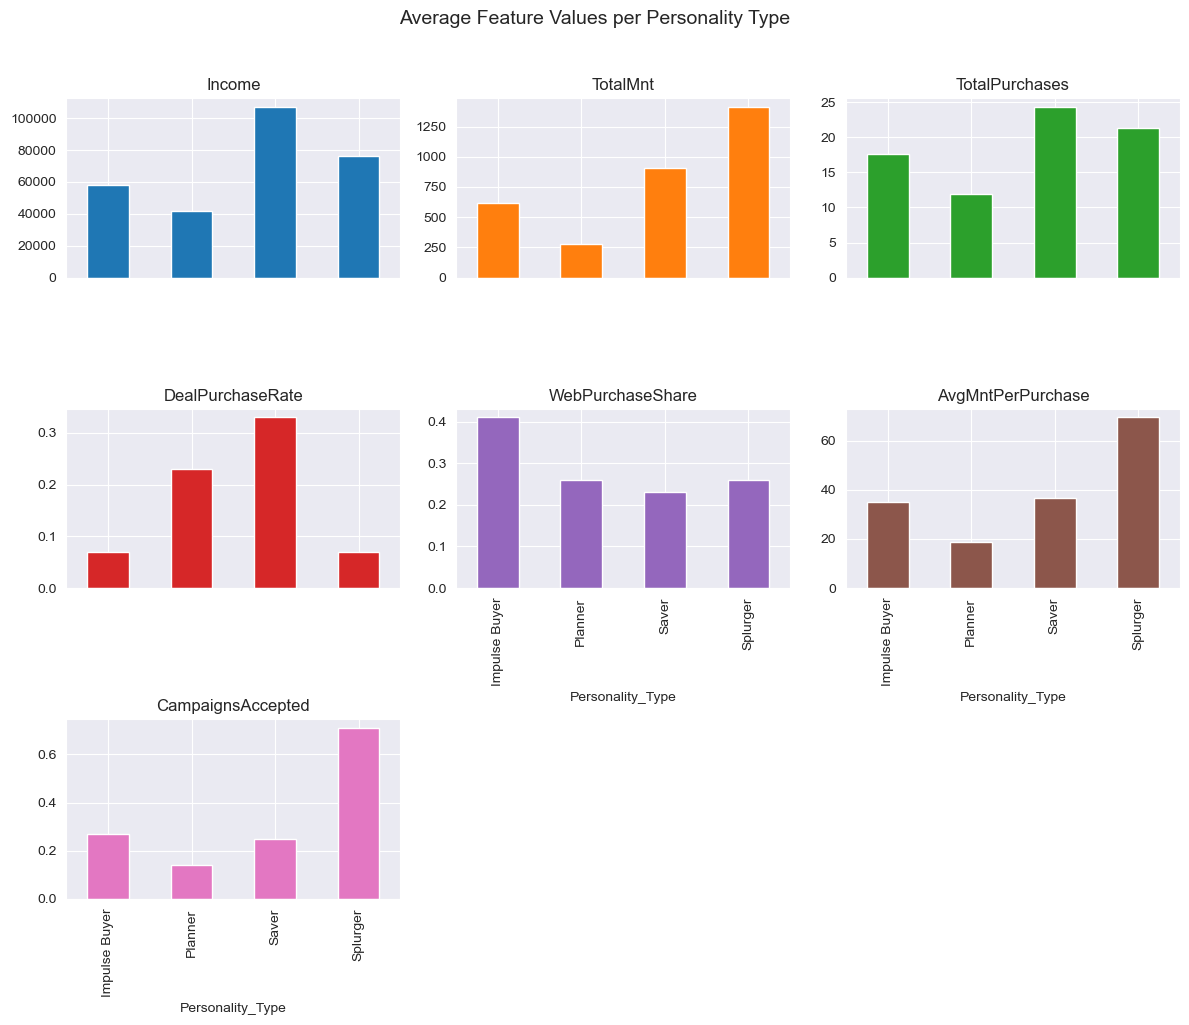

In [ ]:
# Comparing Feature Profiles by Personality Type

summary = df.groupby('personality_type')[['income', 'total_mnt', 'total_purchases',
                                        'deal_purchase_rate', 'webpurchaseshare',
                                        'avg_mnt_per_purchase', 'campaigns_accepted']].mean().round(2)

display(summary)


# Visualizing Personality Types
summary.plot(kind='bar', subplots=True, layout=(3,3), figsize=(12,10), legend=False, sharex=True)
plt.suptitle('Average Feature Values per Personality Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Clustering

Now that we've defined our personality traits, we'll cluster the dataset and analyze the clusters using our defined personality traits as a benchmark.

In [23]:
print(f"Missing values found: {df.isna().sum().sort_values(ascending=False).head(5)}")
df = df.dropna()
print(f"Remaining missing values: {df.isna().sum().head(5)}")

Missing values found: AvgMntPerPurchase    4
ID                   0
Education            0
Marital_Status       0
Income               0
dtype: int64
Remaining missing values: ID                0
Year_Birth        0
Education         0
Marital_Status    0
Income            0
dtype: int64


In [ ]:
# Dropping unusable and redundant columns and split features and target (personality_type)
X, y = df.drop(["ID", "z_revenue","z_cost_contact", "marital_status", "education","personality_type","dt_customer"], axis=1), df["personality_type"]

# Checking for missing values
X.isna().sum().sort_values(ascending=False)


Year_Birth              0
Income                  0
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
Marital_Status_norm     0
Education_norm          0
Age                     0
Children                0
Customer_For_Days       0
Customer_For_years      0
TotalMnt                0
TotalPurchases          0
AvgMntPerPurchase       0
WebPurchaseShare        0
CatalogPurchaseShare    0
StorePurchaseShare      0
DealPurchaseRate        0
CampaignsAccepted       0
Responded               0
Income_level

In [ ]:
# Decalring column with hierachical values for ordinal encoding
hierarchical_cols = ["income_level","spending_level","deal_level","online_level","response_level"]

# Ordinal Encoding the hierachical features
oe = OrdinalEncoder()
X[hierarchical_cols] = oe.fit_transform(X[hierarchical_cols])

# Viewing transformations
X[hierarchical_cols]

,Income_level,Spending_level,Deal_level,Online_level,Response_level
0,2.0,0.0,2.0,0.0,1.0
1,2.0,1.0,0.0,1.0,1.0
2,0.0,2.0,1.0,0.0,1.0
3,1.0,1.0,2.0,2.0,1.0
4,2.0,2.0,0.0,2.0,1.0
...,...,...,...,...,...
2235,2.0,0.0,1.0,0.0,1.0
2236,0.0,2.0,0.0,0.0,2.0
2237,2.0,0.0,1.0,1.0,2.0
2238,0.0,0.0,1.0,2.0,1.0


In [ ]:
# Declaring categorical columns to be One hot Encoded
cat_cols = ["marital_status_norm","education_norm"]
            
# OHEncoding categorical features
ohe = OneHotEncoder(
    handle_unknown="error"
)

ohe.fit(X[cat_cols])

df_ohe = ohe.transform(X[cat_cols]).toarray()

# Viewing results
df_ohe = pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out())

In [ ]:
# Combining ecnoded features with original dataset
df_ohe = pd.concat([X,df_ohe], axis=1)
df_ohe = df_ohe.drop(["marital_status_norm", "education_norm"], axis=1)

df_ohe.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Children',
       'Customer_For_Days', 'Customer_For_years', 'TotalMnt', 'TotalPurchases',
       'AvgMntPerPurchase', 'WebPurchaseShare', 'CatalogPurchaseShare',
       'StorePurchaseShare', 'DealPurchaseRate', 'CampaignsAccepted',
       'Responded', 'Income_level', 'Spending_level', 'Deal_level',
       'Online_level', 'Response_level', 'Marital_Status_norm_Divorced',
       'Marital_Status_norm_Married', 'Marital_Status_norm_Single',
       'Marital_Status_norm_Together', 'Marital_Status_norm_Widow',
       'Education_norm_Basic', 'Education_norm_Graduate',
       'Educatio

In [ ]:
# Declaring numeric features for scaling
numeric = list(set(df_ohe.columns) - set(ohe.get_feature_names_out()) - set(hierarchical_cols))

numeric

['MntGoldProds',
 'MntFruits',
 'Teenhome',
 'StorePurchaseShare',
 'MntSweetProducts',
 'WebPurchaseShare',
 'Year_Birth',
 'Income',
 'Age',
 'Complain',
 'Customer_For_years',
 'TotalMnt',
 'NumStorePurchases',
 'MntMeatProducts',
 'Response',
 'Recency',
 'NumCatalogPurchases',
 'MntWines',
 'NumWebPurchases',
 'AcceptedCmp1',
 'Customer_For_Days',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AvgMntPerPurchase',
 'NumDealsPurchases',
 'MntFishProducts',
 'TotalPurchases',
 'CampaignsAccepted',
 'AcceptedCmp2',
 'Kidhome',
 'NumWebVisitsMonth',
 'CatalogPurchaseShare',
 'DealPurchaseRate',
 'Responded',
 'AcceptedCmp5',
 'Children']

In [29]:
# Checking for missing values
print(f"Missing values: {df_ohe.isna().sum().sort_values(ascending=False)[0]}")

# Dropping rows with missing values
df_ohe = df_ohe.dropna()

# Confirming values dropped
print(f"Missing values left: {df_ohe.isna().sum()[0]}")

Missing values: 4
Missing values left: 0


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_61884/522303409.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Missing values: {df_ohe.isna().sum().sort_values(ascending=False)[0]}")
/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_61884/522303409.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Missing values left: {df_ohe.isna().sum()[0]}")


In [30]:
# Scaling numeric features
scaler = StandardScaler()

# Transforming numeric features
X_scaled = df_ohe.copy()
X_scaled[numeric] = scaler.fit_transform(X_scaled[numeric])

# Confirming transformation
X_scaled[numeric]

,MntGoldProds,MntFruits,Teenhome,StorePurchaseShare,MntSweetProducts,WebPurchaseShare,Year_Birth,Income,Age,Complain,...,TotalPurchases,CampaignsAccepted,AcceptedCmp2,Kidhome,NumWebVisitsMonth,CatalogPurchaseShare,DealPurchaseRate,Responded,AcceptedCmp5,Children
0,0.840378,1.548331,-0.930507,-2.091392,1.472868,0.528614,-0.987835,0.240005,0.987835,-0.097458,...,1.321092,-0.438828,-0.116722,-0.825937,0.700059,2.027013,-0.546849,2.388033,-0.280681,-1.267078
1,-0.730307,-0.636960,0.905825,-0.640951,-0.632605,-1.010129,-1.238367,-0.234769,1.238367,-0.097458,...,-1.159640,-0.438828,-0.116722,1.034296,-0.129751,0.193793,1.373640,-0.418755,-0.280681,1.398443
2,-0.040738,0.568718,-0.930507,0.554468,-0.148588,1.140288,-0.319750,0.782447,0.319750,-0.097458,...,0.798832,-0.438828,-0.116722,-0.825937,-0.544656,-0.367397,-1.198444,-0.418755,-0.280681,-1.267078
3,-0.749462,-0.561605,-0.930507,0.753704,-0.584203,-0.173856,1.266952,-1.027721,-1.266952,-0.097458,...,-0.898511,-0.438828,-0.116722,1.034296,0.285154,-1.115650,0.623449,-0.418755,-0.280681,0.065683
4,-0.557915,0.418008,-0.930507,-0.787757,-0.003383,-0.041812,1.016420,0.246244,-1.016420,-0.097458,...,0.537702,-0.438828,-0.116722,1.034296,-0.129751,0.124875,0.741900,-0.418755,-0.280681,0.065683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,-0.462141,-0.410896,-0.930507,0.288819,-0.414797,0.662418,0.097803,-0.296843,-0.097803,-0.097458,...,1.582221,-0.438828,-0.116722,-0.825937,1.114965,0.048299,-0.960288,-0.418755,-0.280681,-1.267078
2232,-0.787771,-0.636960,-0.930507,2.845687,-0.560002,-2.682676,1.433974,-1.020878,-1.433974,-0.097458,...,-1.420770,-0.438828,-0.116722,-0.825937,-0.544656,-1.115650,0.623449,-0.418755,-0.280681,-1.267078
2233,-0.615379,-0.310422,-0.930507,-1.148098,-0.632605,0.054219,0.682378,24.736597,-0.682378,-0.097458,...,-0.506816,-0.438828,-0.116722,1.034296,0.285154,-0.401408,1.646437,-0.418755,-0.280681,0.065683
2234,-0.672843,-0.586723,-0.930507,0.753704,-0.608404,-0.173856,0.431846,-0.714735,-0.431846,-0.097458,...,-1.420770,-0.438828,-0.116722,1.034296,0.700059,-1.115650,0.623449,-0.418755,-0.280681,0.065683


## KMeans

We'll start with using KMeans algorithm and iterate through a range of clusters at an attempt to find the ideal number of clusters, best known as the elbow method.

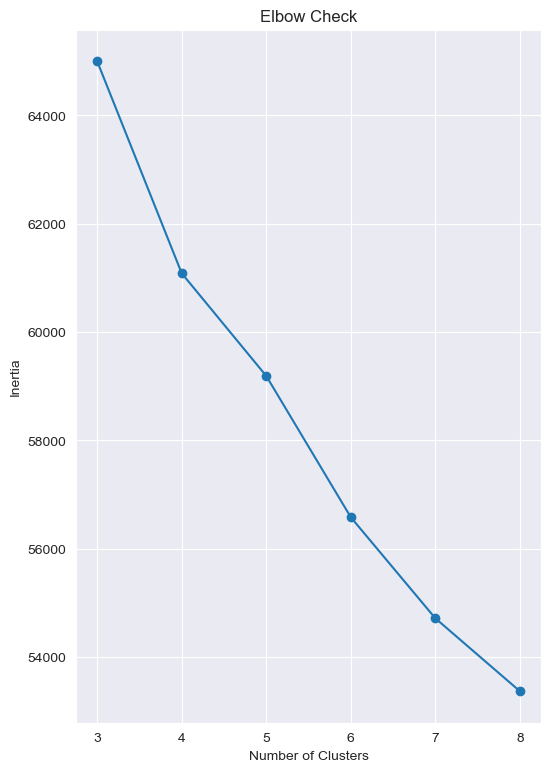

In [31]:
# Declaring random seed value
state = 42

# Clustering data and plotting inertial for optimal number of clusters
inertia_scores = []
cluster_range = range(3,9)

for i in cluster_range:
    # print("number of clusters: ",i)
    kmeans = KMeans(
        n_clusters = i,
        n_init = "auto",
        max_iter = 500,
        # verbose = 4,
        random_state = state,
    )
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

# Plotting inertia scores from each iteration
plt.figure(figsize=(6,9))
plt.plot(cluster_range, inertia_scores, marker = 'o')
plt.xlabel("number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Check")

plt.show()

Using the inertia scores from each iteration we can ideally see an "elbow" which would indicate the ideal number of clusters. Being that there is a slight elbow fowming with a high inertia score between 6-8 clusters, we can conclude that the current dataset as is cannot be properly clustered into a reasonable amount of clusters.

We will try a different approach and reduce the dimensioanlity of our dataset into a small number of principal components. We'll 

In [ ]:
# Declaring number of components
n_components = 2

# Instatiating the PCA tool with 2 principal components
pca = PCA(n_components=n_components, random_state=state)

# Getting principal components and their values
df_pca = pca.fit_transform(X_scaled)

# Converting results into df
df_pca = pd.DataFrame(df_pca)

# Setting n_clusters to 4 as this is the number for our rule-base
kmeans = KMeans(n_clusters=4, random_state=state)
kmeans.fit(df_pca)

# Getting labels and centroids
kmeans_pred = kmeans.predict(df_pca)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [33]:
labels

array([2, 3, 2, ..., 2, 3, 2], shape=(2232,), dtype=int32)

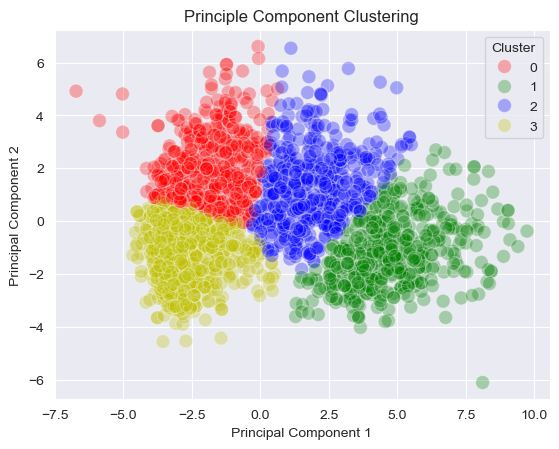

In [34]:
# Plotting clusters using 2 principal components 
ax = sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=kmeans_pred, s=100, alpha=0.3, palette={0:'r',1:'g',2:'b',3:'y'}, legend=True)

plt.title("Principle Component Clustering")
plt.legend(title="Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The model clustered the data nicely after reducing the dimensionality of the data. Cluster 3 is the most compact and dense cluster out of the 4. Cluster 0 follows as next tightest with outliers present. Cluster 2 starts to get a little spase with Cluster 1 being the most sparse cluster of all. 

Overall, we don't see much separation between clusters. We'll add one more component to visualize the data adding an extra dimension so we can get a better perspective on the data's grouping and see if the group show a bit of separation.

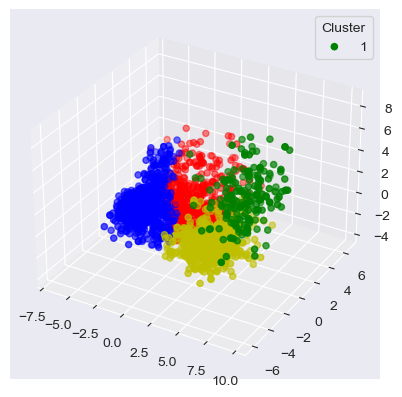

In [35]:
n_components = 3
# Decalaring column names for pc dataframe
col_names = [f"pc_{i+1}" for i in range(n_components)]

# Instantiating PCA 
pca = PCA(n_components=n_components, random_state=state)
df_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(df_pca, columns=col_names)

kmeans_pca = KMeans(n_clusters=4, random_state=state)

pca_pred = kmeans_pca.fit_predict(df_pca)
centroids = kmeans_pca.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r','g','b','y']
cluster_colors = [colors[label] for label in pca_pred]
axes3d.Axes3D.scatter(xs=df_pca["pc_1"], ys=df_pca["pc_2"], zs=df_pca["pc_3"], ax=ax, c=cluster_colors)

# plt.scatter(cluster_centers[:,0], cluster_centers[:,1], label="Cluster Centroids", marker='*', s=300, c='r')
ax.legend(title="Cluster",labels=kmeans_pca.labels_)
plt.show()

This 3d plot gives us a better angle at the clustering. It looks like there are distinct clusters here with little to no separation. Let's try to get a little more dynamic view of the clustering for a closer look into these groupings.

In [36]:
df_pca["cluster"] = pca_pred.astype('str')

fig = px.scatter_3d(
    df_pca,
    x="pc_1",
    y="pc_2",
    z="pc_3",
    color = "cluster",
    color_discrete_map ={'0':'red', '1':"green",'2':"blue",'3':"yellow"},
    title = "Interactive 3D Cluster Map",
    opacity = 0.3
)

fig.add_trace(go.Scatter3d(
    x = centroids[:,0],
    y=centroids[:,1],
    z=centroids[:,2],
    name="centroids",
    mode="markers",
    marker=dict(
        size = 20,
        color = 'black',
        symbol='x'
    )
    )
    
)


fig.update_traces(marker=dict(size=4))
fig.show()

We see that using an interactive 3d model gives us a better idea of the dispersion of the clusters with each cluster's centers, marked with an 'X'. Cluster one shows to be the most sparse grouping meaning the customers pertaining to that group are more diverse and likely have some members of its group closely similar to all other groups. 

This visualization confirms our initial thoughts on the ctructures of each cluster. Although not much space between clusters, this is to be expected when clustering these types of datasets.

Not the best scoring but leaps and bounds better than our first iteration. There is a semblance of an elbow forming between 5 and 6 clusters.


### Initial Principal Component Analysis

In [37]:
# Extracting original column names
original_cols = list(X_scaled.columns)

loadings_df = pd.DataFrame(pca.components_.T, columns=["pc1", "pc_2", "pc_3"], index=original_cols)

loadings_df

,pc1,pc_2,pc_3
Year_Birth,-0.039592,-0.133215,0.246073
Income,0.219102,0.001134,-0.096084
Kidhome,-0.199459,0.037129,0.138104
Teenhome,-0.062211,0.259101,-0.221293
Recency,-0.000120,-0.010374,-0.088384
MntWines,0.246090,0.113206,0.009513
MntFruits,0.198085,-0.053646,-0.083866
MntMeatProducts,0.247886,-0.057506,-0.010125
MntFishProducts,0.206972,-0.056498,-0.086837
MntSweetProducts,0.199073,-0.036328,-0.073157


In [ ]:
print(f"Explained variance by each of our PCs: {pca.explained_variance_ratio_}")
print(f"Total variance in 3Pcs: {pca.explained_variance_ratio_.sum()}")

Explained variance by each of our PCs: [0.26840729 0.08942149 0.07669425]
Total variance in 3Pcs: 0.43452304059449653


We're not seeing enough variance within the dataset. We'll increase the number of components and try with larger number of componets.

In [ ]:
# Setting number of components necessary to cover 90% variance
n_components = 0.9

# Instatiating the PCA tool with 2 principal components
pca = PCA(n_components=n_components, random_state=state)

# Getting principal components and their values
df_pca = pca.fit_transform(X_scaled)

col_names = [f"pc_{i+1}" for i in range(pca.n_components_)]

# Converting results into df
loadings_df = pd.DataFrame(pca.components_.T, columns=col_names, index=original_cols)

In [40]:
# Viewing pca loadings
loadings_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,...,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22
Year_Birth,-0.039592,-0.133215,0.246073,0.392183,0.036468,-0.188041,-0.370099,-0.120356,0.119276,0.005245,...,0.062166,0.039467,0.173165,0.028386,-0.027604,0.005709,0.000519,-0.073892,0.024566,-0.005055
Income,0.219102,0.001134,-0.096084,-0.094248,-0.026772,-0.065481,-0.061830,-0.102783,-0.059806,0.002788,...,0.079377,0.041907,0.241819,-0.198807,0.013638,-0.019717,-0.163919,0.351586,-0.187097,0.113079
Kidhome,-0.199459,0.037129,0.138104,0.046070,-0.180084,-0.194344,-0.088639,0.036324,-0.237501,0.110006,...,-0.041954,0.083925,-0.077528,-0.248306,0.000121,0.021281,0.201830,0.445051,-0.070821,-0.084952
Teenhome,-0.062211,0.259101,-0.221293,-0.271099,-0.110551,0.006301,-0.084054,-0.141597,0.140476,0.116511,...,0.070892,0.144410,0.434011,0.040969,-0.105070,0.001285,-0.005346,-0.329991,0.049758,0.014848
Recency,-0.000120,-0.010374,-0.088384,0.005958,-0.026300,0.018289,-0.183782,0.620837,-0.000934,0.027580,...,0.687709,0.238177,-0.124277,0.083052,-0.028641,0.068901,-0.013404,-0.012453,0.024275,0.024221
MntWines,0.246090,0.113206,0.009513,-0.093779,-0.007984,0.089425,-0.167604,-0.014503,0.013458,-0.020145,...,-0.024553,-0.037252,-0.146089,-0.147325,0.052392,0.076317,0.190569,-0.172338,0.048842,-0.023346
MntFruits,0.198085,-0.053646,-0.083866,0.148168,-0.038973,-0.079965,0.048235,-0.067034,-0.103710,0.157919,...,-0.036774,0.139003,-0.038827,0.088974,-0.226335,-0.216778,-0.015353,-0.127896,-0.174384,-0.216045
MntMeatProducts,0.247886,-0.057506,-0.010125,0.085818,-0.128440,-0.068853,0.034069,0.055766,-0.133252,-0.087536,...,-0.052161,0.066730,-0.052868,-0.011291,-0.004660,0.151156,-0.153118,-0.001244,-0.053479,0.019408
MntFishProducts,0.206972,-0.056498,-0.086837,0.144375,-0.048318,-0.076939,0.058288,-0.003363,-0.102049,0.100125,...,-0.098059,0.063461,0.001364,0.129576,-0.239608,0.022150,0.048438,0.116988,-0.180201,-0.010863
MntSweetProducts,0.199073,-0.036328,-0.073157,0.132549,-0.015338,-0.081979,0.008540,-0.027787,-0.148103,0.145104,...,0.016944,0.051984,0.047166,-0.011861,-0.202164,-0.254082,-0.211217,-0.196926,0.177595,-0.104061


In [41]:
print(f"Total variance captured with first 3 principal compositions: {pca.explained_variance_ratio_[:4].sum():.2%}")
print(f"Total variance catured with first 9 principal compositions: {pca.explained_variance_ratio_[:10].sum():.2%}")
print(f"Total variance captured with all 22 compositions: {pca.explained_variance_ratio_.sum():.2%}")

Total variance captured with first 3 principal compositions: 49.40%
Total variance catured with first 9 principal compositions: 70.84%
Total variance captured with all 22 compositions: 90.93%


The results in total variance captured above gives us a better idea on how to move forward. Being that 22 compositions is a bit too high, we'll iterate through n_components of 9-13 as we will expect the total variance capture to be above 70% which is within industry standard, ideally closer towards 80-85%. 

We'll include silhouette and calinski harabasz scores in during the iterations for additional evaluatoin.

In [ ]:
# Clustering data and plotting inertial for optimal number of clusters
scores = []
n_compositions = list(np.arange(2,11,1))

for i in n_compositions:
    pca = PCA(n_components=i, random_state=state)
    results = pca.fit_transform(X_scaled)
    kmeans = KMeans(
        n_clusters = 5,
        n_init = "auto",
        max_iter = 500,
        # verbose = 4,
        random_state = state
    )
    labels = kmeans.fit_predict(results)
    
    silhouette = silhouette_score(results, labels)
    cal_score = calinski_harabasz_score(results, labels)
    explained_var = pca.explained_variance_ratio_.sum()

    scores.append({
        "n_components" : int(i),
        "inertia" : kmeans.inertia_,
        "silhouette_score" : silhouette,
        "calinski_harabasz_score" : cal_score,
        "explained variance" : round(float(explained_var), 2)
    })

print("RESULTS:")
pd.DataFrame(scores)

RESULTS:


,n_components,inertia,silhouette_score,calinski_harabasz_score,explained variance
0,2,5603.471787,0.405956,2621.924399,0.36
1,3,9807.474748,0.351534,1648.733429,0.43
2,4,14661.066207,0.281211,1120.692786,0.49
3,5,18537.630865,0.268149,897.792799,0.54
4,6,22196.545306,0.234426,756.151058,0.59
5,7,25714.692622,0.215349,655.285105,0.63
6,8,28675.863149,0.171855,582.243769,0.66
7,9,30603.959156,0.196465,554.224627,0.68
8,10,32860.174239,0.190801,516.356546,0.71


We'll move forward with 10 components as we'd ideally want the total variance captures to be at least 70%. Silhoutte score of ~0.2 is normal when clustering datasets consisting of purchases as buyers can be mixed into different clusters.

In [43]:
n_components = 10

# Instantiating PCA with 10 comonents
pca = PCA(n_components=n_components, random_state=state)


col_names = [f"pc_{i+1}" for i in range(n_components)]
pca_df = pd.DataFrame(pca.fit_transform(X_scaled), columns=col_names,)

kmeans = KMeans(n_clusters=4, random_state=state)
kmeans.fit(pca_df)

labels = kmeans.predict(pca_df)
centroids = kmeans.cluster_centers_

In [44]:
pca_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10
0,5.152977,2.900141,0.438031,2.249757,-0.032656,0.223266,3.291165,0.780709,-0.553776,-1.116202
1,-3.322775,-0.255155,-0.694179,-2.326274,-1.318389,-1.350074,1.161173,0.384273,-0.613689,-0.429899
2,1.798972,-0.518305,-1.518717,0.625552,2.365612,0.405491,0.096559,-1.206389,-0.388581,0.163249
3,-3.195746,-2.174805,0.860495,0.587870,0.282075,-0.679338,-0.766509,-0.923899,-0.089672,-0.003108
4,-1.030438,0.092271,-0.348798,0.769497,-0.538143,-2.556678,-1.389822,0.520894,-0.300412,-0.512085
...,...,...,...,...,...,...,...,...,...,...
2227,1.705833,1.618754,-0.940553,1.828676,1.266438,2.289948,-1.135740,0.280319,0.580718,-0.311188
2228,-2.704615,-3.184020,0.972858,2.065439,-1.464526,3.198806,-0.549767,-0.283298,1.294425,-0.242636
2229,2.895738,0.216816,-1.597157,-1.243149,-1.612768,-2.968368,-1.693834,-2.479104,-2.420971,-0.530248
2230,-3.375006,-1.730342,0.706129,0.573973,-0.097376,0.771428,-0.126074,1.058838,-0.321214,-0.084631


In [45]:
# Adding column with cluster prediction
pca_df["cluster"] = labels.astype('str')

fig = px.scatter_3d(
    pca_df,
    x="pc_1",
    y="pc_2",
    z="pc_3",
    color = "cluster",
    color_discrete_map ={'0':'red', '1':"green",'2':"blue",'3':"yellow"},
    title = "Interactive 3D Cluster Map",
    opacity = 0.3
)

fig.add_trace(go.Scatter3d(
    x = centroids[:,0],
    y = centroids[:,1],
    z = centroids[:,2],
    name = "centroids",
    mode = "markers",
    marker = dict(
        size = 20,
        color = 'black',
        symbol='x'
        )
    )
)


fig.update_traces(marker=dict(size=4))
fig.show()

The clusters got a bit more interesting after increasing the principal components up to 10. Now that our dataset has 70% of the original dataset's variance we see the largest and most dispersed cluster is cluster 2 showing it contains the most diverse group of buyers. 

Cluster 3 remains the most compact grouping with some of its group crossing the cluster 0 border. 

Cluster 0 mix a bit as well. We still see there is not any separation between the clusters but some clusters are more like some tha other clusters. The KMeans algorithm has done a decent job in clustering these groups, given the type of data we're working with.

### Cluster Analysys

In [46]:
# Checking cluster labels vs rule-bsaed grouping
ari = adjusted_rand_score(y.iloc[X_scaled.index], kmeans_pred)
nmi = normalized_mutual_info_score(y.iloc[X_scaled.index], kmeans_pred)
v = v_measure_score(y.iloc[X_scaled.index], kmeans_pred)
print(f"ARI score: {ari:.2f}\nNMI score: {nmi:.2f}\nV-Measure score: {v:.2f}")

ARI score: 0.03
NMI score: 0.03
V-Measure score: 0.03


Here we can see our clusters and rule-based groupings have not matched as scores closer to 1 indicate cluster and grouping matches. This is normal but being that we need strict grouping to match buyers with specific spending personalities we will move forward using our rule-based grouping. 

Let's take a descriptive look at the measures pf location for our personality types so have a better idea for our scoring logic.

In [ ]:
cols = ["income",
"total_mnt",
"total_purchases",
"avg_mnt_per_purchase",
"deal_purchase_rate",
"webpurchaseshare",
"storepurchaseshare"]

for type in df["personality_type"].unique():
    print(f"Displaying {type} description:")
    display(df[df["personality_type"]==type][cols].describe().T.round(2))

Displaying Planner description:


,count,mean,std,min,25%,50%,75%,max
Income,1503.0,41393.83,15405.01,1730.00,30370.00,41014.00,52943.50,162397.00
TotalMnt,1503.0,281.86,326.97,8.00,48.00,120.00,433.00,1895.00
TotalPurchases,1503.0,12.00,7.02,1.00,6.00,10.00,17.00,43.00
AvgMntPerPurchase,1503.0,18.82,45.06,0.53,7.50,13.71,24.65,1679.00
DealPurchaseRate,1503.0,0.23,0.09,0.00,0.17,0.24,0.29,1.00
WebPurchaseShare,1503.0,0.26,0.09,0.00,0.20,0.25,0.33,0.56
StorePurchaseShare,1503.0,0.42,0.13,0.00,0.33,0.42,0.50,1.00


Displaying Impulse Buyer description:


,count,mean,std,min,25%,50%,75%,max
Income,116.0,58125.19,18750.11,4428.00,50322.00,59173.00,65651.25,157733.00
TotalMnt,116.0,615.03,316.31,32.00,348.25,608.00,794.00,1665.00
TotalPurchases,116.0,17.66,5.78,1.00,13.00,19.00,21.00,28.00
AvgMntPerPurchase,116.0,34.85,18.62,10.26,26.29,32.22,37.50,186.50
DealPurchaseRate,116.0,0.07,0.03,0.00,0.05,0.08,0.10,0.11
WebPurchaseShare,116.0,0.41,0.14,0.30,0.33,0.39,0.43,1.00
StorePurchaseShare,116.0,0.39,0.11,0.00,0.35,0.41,0.45,0.55


Displaying Splurger description:


,count,mean,std,min,25%,50%,75%,max
Income,597.0,76382.50,8885.20,63033.00,69867.00,75693.00,81741.00,157146.00
TotalMnt,597.0,1413.43,375.62,841.00,1104.00,1370.00,1672.00,2525.00
TotalPurchases,597.0,21.30,4.55,10.00,18.00,21.00,25.00,35.00
AvgMntPerPurchase,597.0,69.45,23.78,28.77,54.18,66.41,78.70,173.23
DealPurchaseRate,597.0,0.07,0.04,0.00,0.04,0.06,0.08,0.24
WebPurchaseShare,597.0,0.26,0.09,0.00,0.19,0.25,0.31,0.58
StorePurchaseShare,597.0,0.40,0.10,0.00,0.32,0.41,0.48,0.69


Displaying Saver description:


,count,mean,std,min,25%,50%,75%,max
Income,20.0,107103.20,134728.49,62998.00,64413.00,66426.50,74961.25,666666.00
TotalMnt,20.0,908.10,539.19,62.00,444.00,836.00,1337.25,1750.00
TotalPurchases,20.0,24.35,7.97,11.00,19.00,22.50,26.50,44.00
AvgMntPerPurchase,20.0,36.58,22.51,5.64,20.64,27.05,47.33,97.22
DealPurchaseRate,20.0,0.33,0.05,0.26,0.30,0.32,0.36,0.44
WebPurchaseShare,20.0,0.23,0.13,0.00,0.16,0.24,0.33,0.44
StorePurchaseShare,20.0,0.26,0.12,0.00,0.23,0.26,0.32,0.43


We'll use this data to develop a scoring logic to implement in our application matching users with our rule-based personality types.

## Conlusion

We were able to put together a solid rule based grouping that can logically identify hsopper apending personality without all the noise. After clustering we see the KMeans algorithm clustered the data into groups that do not match up with our rule based groups.

In order to properly identify user with their spending personlity types, we must use our rule-based system as it would be a trivial approach to come up with questions and scoring logic.